# Thanker Experiment Power Analysis
[J. Nathan Matias](https://github.com/natematias)
March 2019

Some components of this are drawn from [github.com/natematias/poweranalysis-onlinebehavior](https://github.com/natematias/poweranalysis-onlinebehavior).

Eventually, this power analysis code will ask a series of questions of [historical data prepared by Max Klein](https://docs.google.com/document/d/1VTisnIBafttzCNPAlEV149Mhyqc7D2Q_96OA9hKmp_M/edit#) and produce a series of answers used for power analysis and study design in CivilServant's research with Wikipedians on [the effects of giving thanks to other Wikipedians](https://meta.wikimedia.org/wiki/Research:Testing_capacity_of_expressions_of_gratitude_to_enhance_experience_and_motivation_of_editors):
* The experiment plan is on Overleaf: [Experiment Plan: Mentoring and Protection in Wikipedia Moderation](https://www.overleaf.com/project/5c376605f882d02f5b8c714a)

This analysis will define and report the following:

* Assumptions about minimum observable treatment effects for each DV
* Reports on the statistical power, bias, and type S error rate for all possible estimators, given the above assumptions
* Data-driven decisions:
    * Decisions about the final set of measures to use
    * Decisions about the final estimators to use
    * Decisions about the sample size to specify for the experiment
    * Decisions about any stop rules to use in the experiment

**Note:** Since the thanker study will involve a single group of participants from multiple language Wikipedias, this document reports a single power analysis. The experiment for thanks recipients covers multiple language Wikipedias.

In [507]:
## LOAD LIBRARIES
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(gmodels)
library(DeclareDesign)
library(skimr)
library(corrplot)
library(blockTools)
library(beepr)
# ## Installed DeclareDesign 0.13 using the following command:
# # install.packages("DeclareDesign", dependencies = TRUE,
# #                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] beepr_1.3            blockTools_0.6-3     corrplot_0.84       
 [4] gmodels_2.18.1       skimr_1.0.4          DeclareDesign_0.12.0
 [7] estimatr_0.14        fabricatr_0.6.0      randomizr_0.16.1    
[10] viridis_0.5.1        viridisLite_0.3.0    forcats_0.3.0       
[13] stringr_1.3.1        pur

# Configuration Settings

In [15]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/datasets/power_analysis"

# Step one: Creating a Plausible Population to Draw From

### Load Thankee Power Analysis Datasets As Proxy for Thankers

In [188]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/datasets/power_analysis"
power.df <- read.csv(file.path(data.path, "thanker_power_analysis_data_for_sim_treatment_20180306.csv"))

simulated.treatment.date <- as.Date("20180306", "%Y%M%D")

### Load Power Analysis Utility Methods

In [207]:
source("../power-analysis-utilities.R")
source("../wikipedia-gratitude-utilities.R")

# Summarize Thanker Power Analysis Dataframe

In [474]:
subset.summarize.thanker.data <- function(thanker.df, l){
    sim.df <- subset(thanker.df, lang==l)
    sim.df$supportive_90_pre_treatment <- rowSums(sim.df[,
                                                      c("support_talk_90_pre_treatment",
                                                        "wikithank_90_pre_treatment",
                                                        "wikilove_90_pre_treatment")], na.rm=TRUE)
    sim.df$protective_90_pre_treatment <- rowSums(sim.df[,
                                                      c("block_actions_90_pre_treatment",
                                                        "num_reverts_90_pre_treatment")], na.rm=TRUE)
    
    sim.df$supportive_90_post_treatment <- rowSums(sim.df[,
                                                       c("support_talk_90_post_treatment",
                                                         "wikithank_90_post_treatment",
                                                         "wikilove_90_post_treatment")], na.rm=TRUE)
    sim.df$protective_90_post_treatment <- rowSums(sim.df[,
                                                       c("block_actions_90_post_treatment",
                                                          "num_reverts_90_post_treatment")], na.rm=TRUE)
    
    ### REMOVING OUTLIERS beyond 99% confidence interval (MIGHT BE A BAD IDEA, UNSURE)
    sim.support.mean <- mean(sim.df$supportive_90_pre_treatment)
    sim.support.sd   <- sd(sim.df$supportive_90_pre_treatment)
    sim.df <- subset(sim.df, supportive_90_pre_treatment <= sim.support.mean + 2.58* sim.support.sd)
    
    sim.protect.mean <- mean(sim.df$protective_90_pre_treatment)
    sim.protect.sd   <- sd(sim.df$protective_90_pre_treatment)
    sim.df <- subset(sim.df, protective_90_pre_treatment <= sim.protect.mean + 2.58* sim.protect.sd)
    
    
    corrplot(cor(sim.df[,c("support_talk_90_pre_treatment",
                     "project_talk_90_pre_treatment",
                     "wikithank_90_pre_treatment",
                     "wikilove_90_pre_treatment",
                     "num_reverts_90_pre_treatment")]),
            type="upper", method = "ellipse")
    
    sim.df$supportive_diff_180_days <- sim.df$supportive_90_post_treatment - sim.df$supportive_90_pre_treatment

    sim.df$protective_diff_180_days <- sim.df$protective_90_post_treatment - sim.df$protective_90_pre_treatment
    
    sim.df$supportive_protective_ratio_pre_90_days <- sim.df$supportive_90_pre_treatment / (sim.df$supportive_90_pre_treatment +sim.df$protective_90_pre_treatment + 1)  

    plt <- ggplot(sim.df, aes(protective_90_pre_treatment, supportive_90_pre_treatment, color=supportive_protective_ratio_pre_90_days)) +
        geom_abline(intercept = 0, color="grey", linetype="dashed") +
        geom_jitter(size=1) +
        scale_colour_gradient(name="% Support Actions") +
        theme_bw() +
        ggtitle(paste(l, "Supportive and Protective Actions Before Treatment"))
    print(plt)

    plt2 <- ggplot(sim.df, aes(protective_diff_180_days, supportive_diff_180_days , color=supportive_protective_ratio_pre_90_days)) +
        geom_hline(yintercept = 0, color="grey", linetype="dashed") +        
        geom_vline(xintercept = 0, color="grey", linetype="dashed") +        
        geom_point() +
        theme_bw() +
        scale_colour_gradient(name="% Support Actions") +
        ggtitle(paste(l, "Diff in Supportive and Protective Actions"))
    print(plt2)
    
    plt3 <- ggplot(sim.df, aes(log1p(wikithank_90_pre_treatment))) +
        geom_histogram() +         
        theme_bw() +
        ggtitle(paste(l, "Thanks Given 90 Days Previously"))

    print(plt3)

    sim.df
}

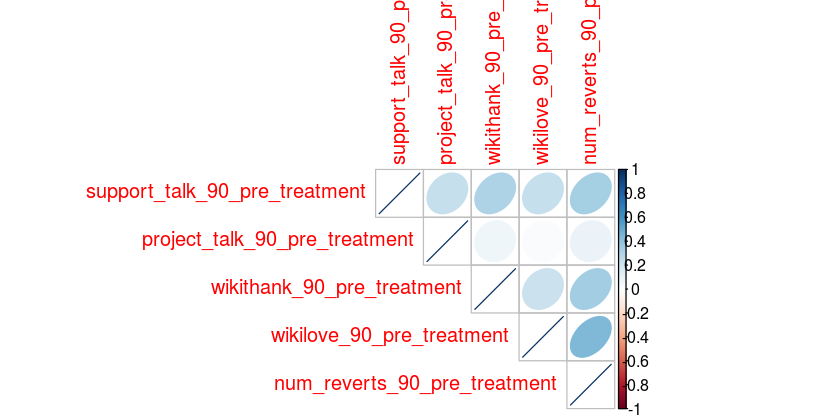

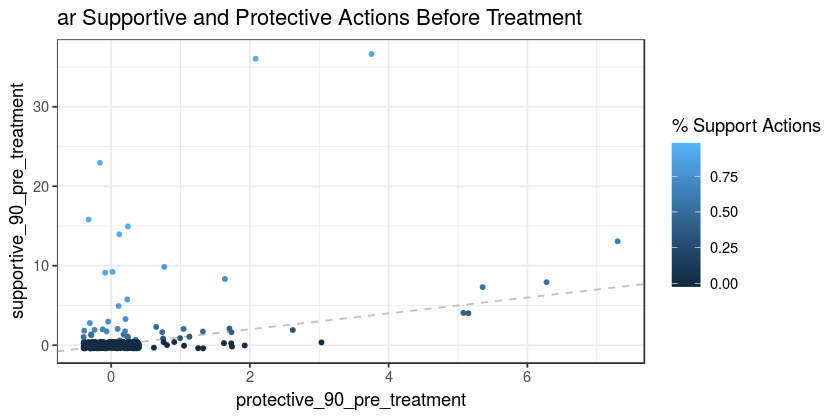

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


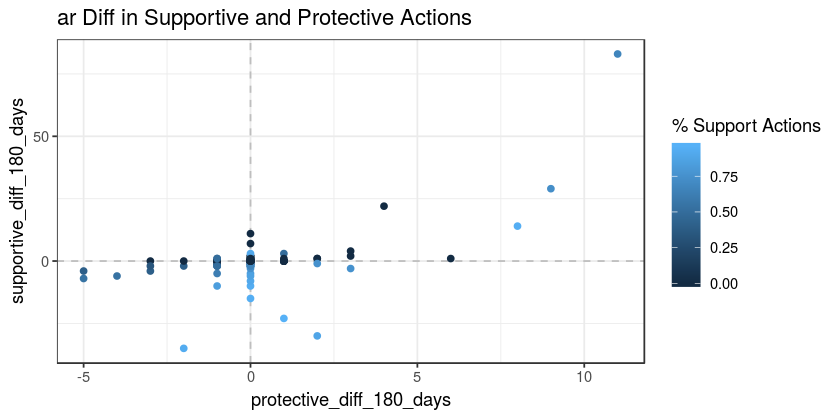

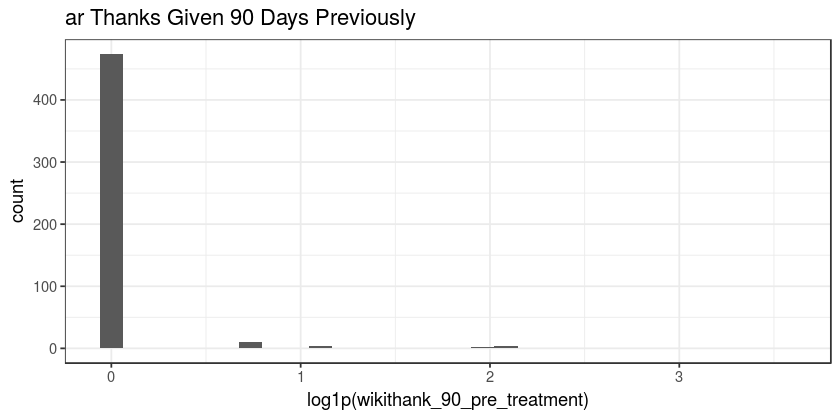

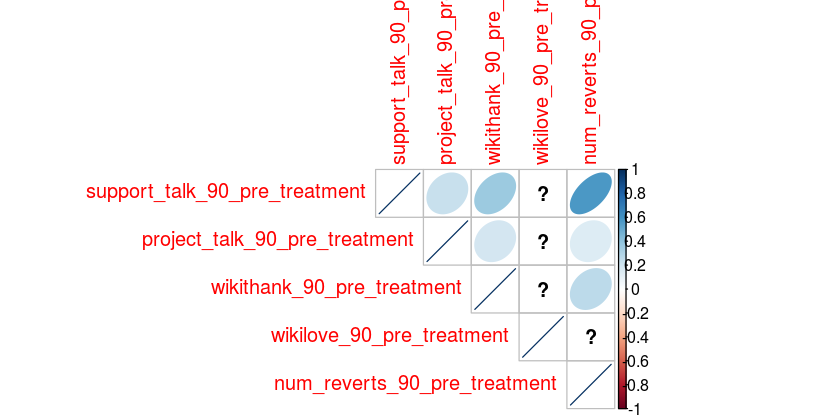

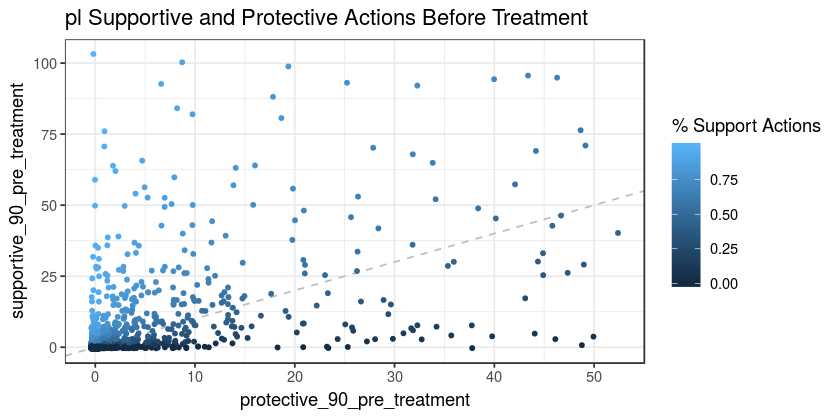

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


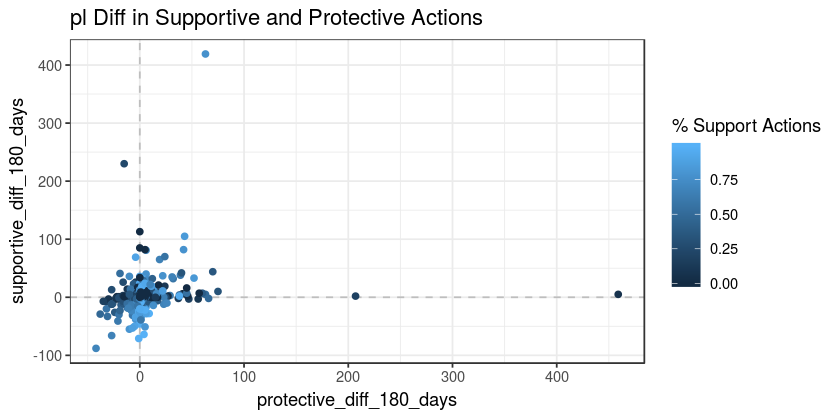

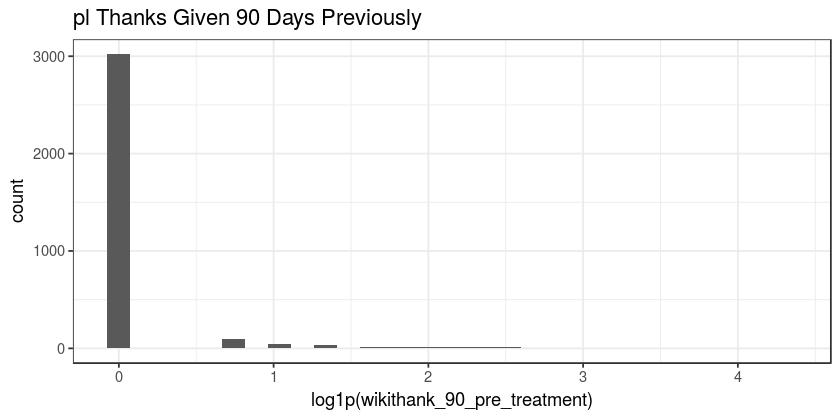

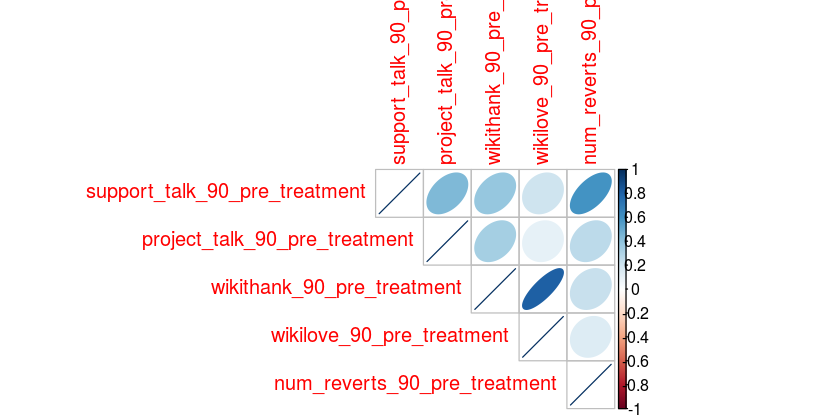

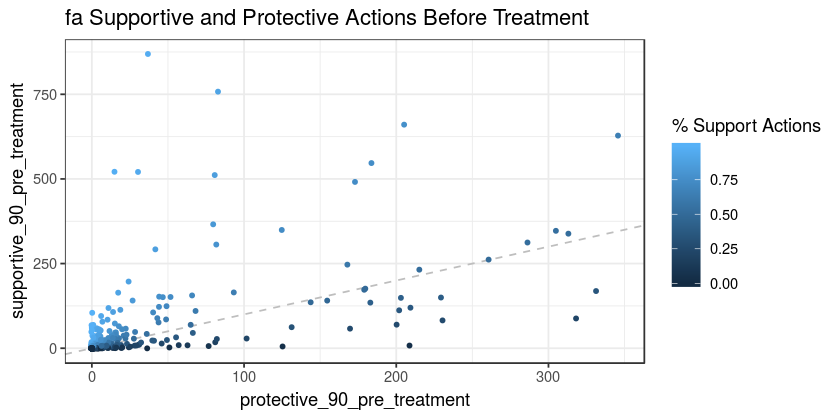

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


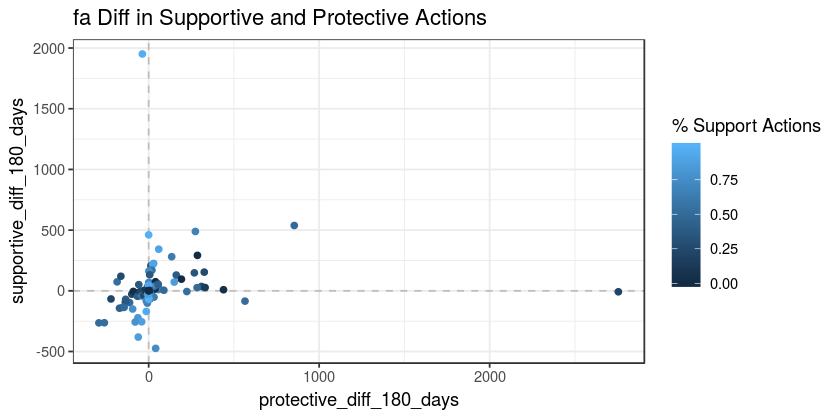

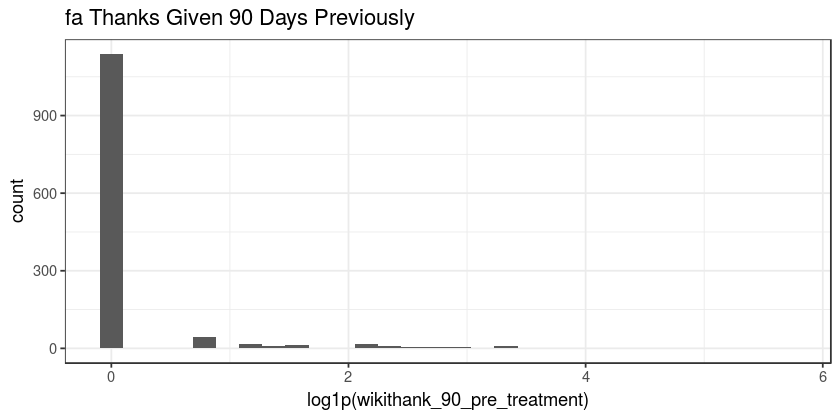

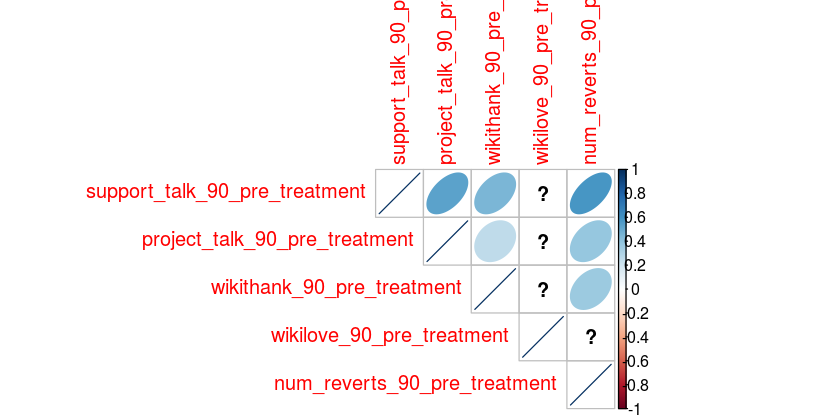

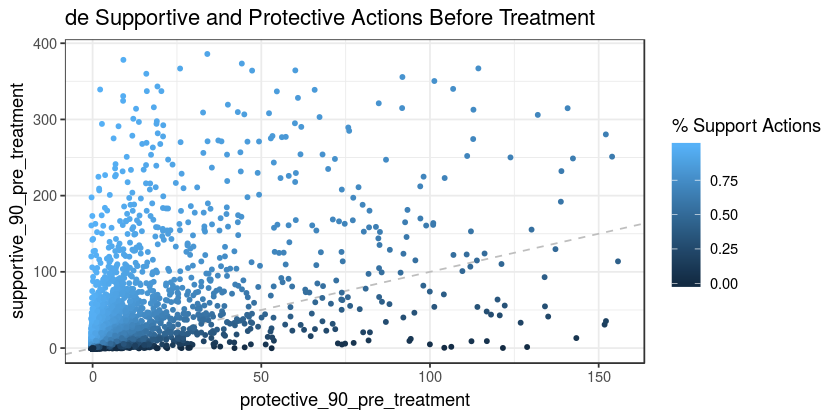

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


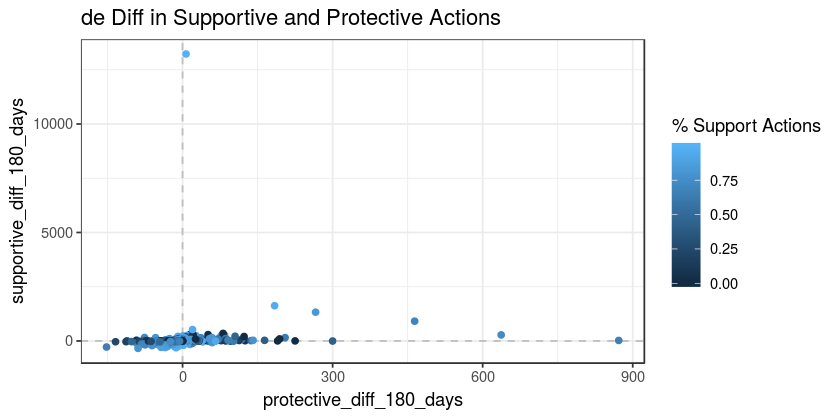

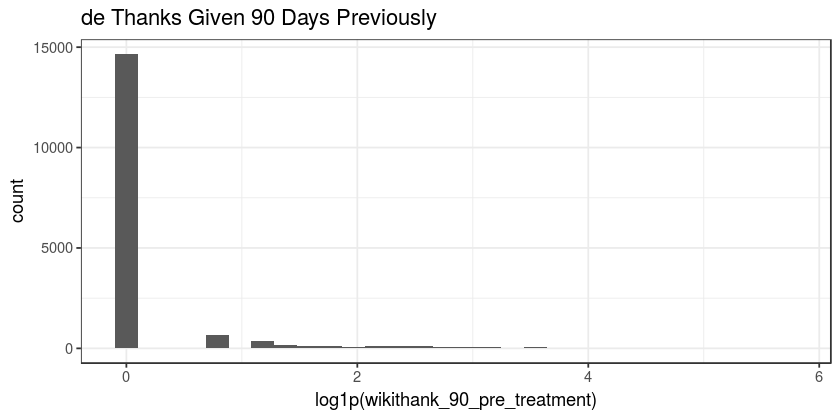

In [475]:
ar.thanker.df <- subset.summarize.thanker.data(power.df, "ar")
pl.thanker.df <- subset.summarize.thanker.data(power.df, "pl")
fa.thanker.df <- subset.summarize.thanker.data(power.df, "fa")
de.thanker.df <- subset.summarize.thanker.data(power.df, "de")
power.sub.df <- rbind(ar.thanker.df,pl.thanker.df, fa.thanker.df,de.thanker.df)

# Set Up Power Analysis Configuration
We make the assumption that Wikipedians group themselves into deletionists and inclusionists and that these groups will be reflected in the distribution of the survey.protectiveness.index, which will use the first component in a Principal Components Analysis to combine:
* Monitoring and correcting potentially damaging content
* Answering newcomer questions or mentoring newcomers in other ways

### Test Principal Components Analysis Setup
Survey questions are from the [Data Format Description: Thanker and Thankee Randomizations](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit#)

In [698]:
## FIRST STEP: GENERATE NEGATIVELY CORRELATED ITEMS
generate.survey.answers <- function(n.size, output=FALSE){
    n.size = n.size/2
    
    test.pca.df <- expand.grid(
        inclusionist = factor(c(0,1)),
        id = seq(n.size)
    )

    test.pca.df$pre_mentoring <- draw_ordered(rnorm(n.size,2,1), 
                                               breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf))
    test.pca.df[test.pca.df$inclusionist==1,]$pre_mentoring <- draw_ordered(rnorm(n.size, 4, 1), 
                                                                             breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf))

    test.pca.df$pre_monitoring_damaging_content <- draw_ordered(rnorm(n.size,2,1), 
                                               breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf))
    test.pca.df[test.pca.df$inclusionist==1,]$pre_monitoring_damaging_content <- draw_ordered(rnorm(n.size, 4, 1), 
                                                                             breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf))

    test.pca.df$pre_newcomer_intent <- draw_ordered(rnorm(n.size,4,1), 
                                               breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf))
    test.pca.df[test.pca.df$inclusionist==1,]$pre_newcomer_intent <- draw_ordered(rnorm(n.size, 2, 1), 
                                                                             breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf))

    test.pca.df$pre_newcomer_capability <- draw_ordered(rnorm(n.size,2,1), 
                                               breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf))
    test.pca.df[test.pca.df$inclusionist==1,]$pre_newcomer_capability <- draw_ordered(rnorm(n.size, 4, 1), 
                                                                             breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf))

    
    ## SECOND STEP: CREATE FIRST INDEX WITH PCA
    ## Note that I pull out the inclusionist variable
    ## which was purely used to simulate the other variables
    test.pca <- prcomp(test.pca.df[c("pre_mentoring", "pre_monitoring_damaging_content",
                                     "pre_newcomer_intent", "pre_newcomer_capability")], center = TRUE ,scale = TRUE)
    test.pca.df$protectiveness <- test.pca$x[,"PC1"]
    if(output){
        print(summary(test.pca))

        print("Protectiveness Index:")
        print(summary(test.pca.df$protectiveness))
        print("Correlations:")
        print(paste("Mentoring:", cor(test.pca.df$protectiveness, test.pca.df$pre_mentoring)))
        print(paste("Monitoring Damaging Content:", cor(test.pca.df$protectiveness, test.pca.df$pre_monitoring_damaging_content)))
    }
    test.pca.df
}

In [700]:
test.pca <- generate.survey.answers(50, output=TRUE)
print(nrow(test.pca))

Importance of components:
                         PC1   PC2   PC3    PC4
Standard deviation     1.585 0.841 0.654 0.5940
Proportion of Variance 0.628 0.177 0.107 0.0882
Cumulative Proportion  0.628 0.805 0.912 1.0000
[1] "Protectiveness Index:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -2.926  -1.486   0.132   0.000   1.405   2.521 
[1] "Correlations:"
[1] "Mentoring: 0.680478421521773"
[1] "Monitoring Damaging Content: 0.767081073650812"
[1] 50


### Configure Thanker Dataframe

In [705]:
pa.config.thanker <- data.frame(
    n.max    = 1000, # max number of observations
    n.min    = 100,  # min number of observations

    ## Index of protectiveness (continuous from -2 to 2)
    ## Used for matching (these are assumptions)
    survey.protectiveness.mean.deletionist   = -1,
    survey.protectiveness.mean.inclusioninst = 1,
    survey.corrections.sd                    = 0.5,
    
    total.participation.rate = 0.8, # let's assume 80% of consented participants complete the study

    # the minimum effect we want to be able to observe:
    # a five edit increase in the number of protective edits over 90 days
    # assumption, the treatment group has the same standard deviation
    protective.edit.diff.mean.effect = 6,
    protective.edit.diff.sd.effect =   3,
    
    # the minimum effect we want to be able to observe:
    # a five edit increase in the number of protective edits over 90 days
    # assumption, the treatment group has the same standard deviation
    supportive.edit.diff.mean.effect = 6,
    supportive.edit.diff.sd.effect =   3,
    
    ## EFFECT ON DIFFERENCE IN NUMBER OF THANKS GIVEN
    thanks.given.diff.treat = 1.5,
    thanks.given.diff.treat.sd = 0.5,
    
    ## SURVEY RESULTS (ASSUMPTION: NO DIFFERENCE OVER TIME BETWEEN SURVEYS)
    
    ## Contributing to Wikipedia feels emotionally draining) (1 to 5)
    # We want to see an effect of at least -0.3 if any exists
    survey.draining.pre.mean   = 3,
    survey.draining.pre.sd     = 1,
    survey.draining.post.mean.ctl = 3,
    survey.draining.post.sd       = 1,
    survey.draining.post.mean.treat = 2.55,

    ## Effect on Protectiveness Index
    ## Here, we assume that answers will be relatively stable
    ## but we want to be able to observe at least an 0.2 increase
    ## in the difference between protectiveness measures
    survey.diff.protectiveness.treat        = 0.2,
    survey.diff.protectiveness.ctl          = 0.0,
    survey.diff.protectiveness.sd           = 0.2

)

# Creating a Sample of Thankers Proportional to What We Expect from Volunteers

In this study, we will publish banner ads to the following groups:
* In Arabic Wikipedia, accounts that have "autoreviewer" status.
* In German Wikipedia accounts that have permission to flag revisions.
* In Persian Wikipedia, accounts registered for at least one year with at least 500 edits.
* In Polish Wikipedia, accounts with permission to flag revisions.

In [669]:
fa.volunteer.count <- 72  ## 75 stated
pl.volunteer.count <- 72  ## 75
ar.volunteer.count <- 72  ## 75 stated
de.volunteer.count <- 300 ## 300 stated

included.experience.levels <- c("730", "365", "1460", "2920")

In [670]:
## THESE SCRIPTS WILL EVENLY SAMPLE FROM ACROSS EXPERIENCE LEVELS
generate.complete.thanker.sample <- function(sub.df){
    fa.volunteers <- generate.sample.from.reference(subset(sub.df, lang=="fa" & fa_is_edits_enough=="True"), 
                               fa.volunteer.count, 
                                c("lang", 
                                  "wikithank_90_pre_treatment",      "wikilove_90_pre_treatment",
                                  "wikithank_90_post_treatment",     "wikilove_90_post_treatment",
                                  "block_actions_90_pre_treatment",  "support_talk_90_pre_treatment",
                                  "block_actions_90_post_treatment", "support_talk_90_post_treatment",
                                  "project_talk_90_pre_treatment",   "num_reverts_90_pre_treatment",
                                  "project_talk_90_post_treatment",  "num_reverts_90_post_treatment"
                                ), replacement= FALSE)

    pl.volunteers <- generate.sample.from.reference(subset(sub.df, lang=="pl" & pl_is_editor =="True"), 
                               pl.volunteer.count, 
                                c("lang", 
                                 "wikithank_90_pre_treatment",      "wikilove_90_pre_treatment",
                                 "wikithank_90_post_treatment",     "wikilove_90_post_treatment",
                                 "block_actions_90_pre_treatment",  "support_talk_90_pre_treatment",
                                 "block_actions_90_post_treatment", "support_talk_90_post_treatment",
                                 "project_talk_90_pre_treatment",   "num_reverts_90_pre_treatment",
                                 "project_talk_90_post_treatment",  "num_reverts_90_post_treatment"
                                ), replacement= FALSE)

    de.volunteers <- generate.sample.from.reference(subset(sub.df, lang=="de" & de_is_autoreviewer =="True"), 
                               de.volunteer.count, 
                                c("lang", 
                                 "wikithank_90_pre_treatment",      "wikilove_90_pre_treatment",
                                 "wikithank_90_post_treatment",     "wikilove_90_post_treatment",
                                 "block_actions_90_pre_treatment",  "support_talk_90_pre_treatment",
                                 "block_actions_90_post_treatment", "support_talk_90_post_treatment",
                                 "project_talk_90_pre_treatment",   "num_reverts_90_pre_treatment",
                                 "project_talk_90_post_treatment",  "num_reverts_90_post_treatment"
                                ), replacement= FALSE)

    ar.volunteers <- generate.sample.from.reference(subset(sub.df, lang=="ar" & ar_is_autoreview =="True"), 
                               ar.volunteer.count, 
                                c("lang", 
                                 "wikithank_90_pre_treatment",      "wikilove_90_pre_treatment",
                                 "wikithank_90_post_treatment",     "wikilove_90_post_treatment",
                                 "block_actions_90_pre_treatment",  "support_talk_90_pre_treatment",
                                 "block_actions_90_post_treatment", "support_talk_90_post_treatment",
                                 "project_talk_90_pre_treatment",   "num_reverts_90_pre_treatment",
                                 "project_talk_90_post_treatment",  "num_reverts_90_post_treatment"
                                ), replacement= FALSE)


    return.df <- rbind(ar.volunteers, de.volunteers, fa.volunteers, pl.volunteers)
    return.df$id <- seq.int(nrow(return.df))
    return.df
}

# Conduct a Power Analysis
## Step One: Simulate Survey Answers
(note: these survey answers are not correlated with the observational data)

In [677]:
generate.sim.sample <- function(ps.df){
    ## generate complete thanker sample
    d.df <- generate.complete.thanker.sample(ps.df)
    d.df$lang <- factor(d.df$lang)
    ## generate survey answers
    d.df <- cbind(d.df, generate.survey.answers(nrow(d.df)))
    
    ## conduct randomization blocks
    obj = block(data=d.df,
                n.tr = 2,
                id.vars="id",
                block.vars = c("wikithank_90_pre_treatment", "support_talk_90_pre_treatment","protectiveness"),
                distance ="mahalanobis"
                )
    d.df$blocks <- createBlockIDs(obj,
                                   data=d.df,
                                   id.var = "id")
    d.df
}

In [706]:
generate.diagnosis <- function(pa.config){
    sample.size <- fa.volunteer.count + pl.volunteer.count + 
          ar.volunteer.count + de.volunteer.count 
    design <- 
        declare_population(
            data = generate.sim.sample(power.sub.df),
            pre_survey_draining = draw_ordered(rnorm(sample.size,pa.config$survey.draining.pre.mean,
                                                     pa.config$survey.draining.pre.sd), 
                                                   breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf)),
            experiment.completion = rbinom(sample.size, 1, pa.config$total.participation.rate)
        ) +
        declare_potential_outcomes(

            ## Difference in Thanks Given
            TGD_Z_0 = wikithank_90_post_treatment - wikithank_90_pre_treatment,
            TGD_Z_1 = (wikithank_90_post_treatment + 
                       round(rnorm(sample.size, mean=pa.config$thanks.given.diff.treat, sd = pa.config$thanks.given.diff.treat.sd)) -
                       wikithank_90_pre_treatment),   

            ## Difference in Protective Edits
            PE_Z_0 = num_reverts_90_post_treatment - num_reverts_90_pre_treatment,
            PE_Z_1 = (num_reverts_90_post_treatment + 
                      rnorm(sample.size, mean=pa.config$protective.edit.diff.mean.effect, sd = pa.config$protective.edit.diff.sd.effect) -
                      num_reverts_90_pre_treatment),  

            ## Difference in Supportive Edits (number of edits made to talk pages)
            SE_Z_0 = support_talk_90_post_treatment - support_talk_90_pre_treatment,
            SE_Z_1 = (support_talk_90_post_treatment + 
                      rnorm(sample.size, mean=pa.config$supportive.edit.diff.mean.effect, sd = pa.config$supportive.edit.diff.sd.effect) -
                      support_talk_90_pre_treatment),

            ## Difference in Protectiveness Survey Index  
            ## including the protectiveness measure is a bit redundant
            ## but it reflects how the assumptions work
            PS_Z_0 = protectiveness + 
                     rnorm(sample.size, pa.config$survey.diff.protectiveness.ctl, pa.config$survey.diff.protectiveness.sd) -
                     protectiveness,
            PS_Z_1 = protectiveness + 
                     rnorm(sample.size, pa.config$survey.diff.protectiveness.treat, pa.config$survey.diff.protectiveness.sd) -
                     protectiveness,

            ## Difference in Draining (Burnout) Index  
            BO_Z_0 = draw_ordered(rnorm(sample.size,pa.config$survey.draining.post.mean.ctl,
                                               pa.config$survey.draining.post.sd), 
                                                   breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf)) - pre_survey_draining,
            BO_Z_1 = draw_ordered(rnorm(sample.size,pa.config$survey.draining.post.mean.treat,
                                               pa.config$survey.draining.post.sd), 
                                                   breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, Inf)) - pre_survey_draining

        )  +
        declare_assignment(prob = .5, blocks = blocks) +
        declare_estimand(ate_TGD_1_0 = pa.config$thanks.given.diff.treat,
                         ate_PE_1_0  = pa.config$protective.edit.diff.mean.effect,
                         ate_SE_1_0  = pa.config$supportive.edit.diff.mean.effect,
                         ate_PS_1_0  = pa.config$survey.diff.protectiveness.treat - pa.config$survey.diff.protectiveness.ctl,
                         ate_B0_1_0  = pa.config$survey.draining.post.mean.treat - pa.config$survey.draining.post.mean.ctl) +
        declare_reveal(outcome_variables = c("TGD", "PE", "SE", "PS", "BO"), assignment_variables=c("Z")) +

        ## ESTIMATORS
        declare_estimator(formula = TGD ~ Z,
                          model = difference_in_means,
                          estimand = "ate_TGD_1_0",
                          label="est-ate_TGD_1_0") +
        declare_estimator(formula = PE ~ Z,
                          model = difference_in_means,
                          estimand = "ate_PE_1_0",
                          label="est-ate_PE_1_0") +
        declare_estimator(formula = SE ~ Z,
                          model = difference_in_means,
                          estimand = "ate_SE_1_0",
                          label="est-ate_SE_1_0") +
        declare_estimator(formula = PS ~ Z,  
            model    = difference_in_means,
            subset   = experiment.completion == 1, 
            estimand = "ate_PS_1_0", 
            label    = "est-ate_PS_1_0-p") +
        declare_estimator(formula = BO ~ Z,  
            model    = difference_in_means,
            subset   = experiment.completion == 1, 
            estimand = "ate_B0_1_0", 
            label    = "est-ate_BO_1_0-p")
    diagnose_design(design)
}


In [707]:
generate.diagnosis(pa.config.thanker)


Research design diagnosis based on 500 simulations. Diagnosand estimates with bootstrapped standard errors in parentheses (100 replicates).

 Design Label Estimand Label  Estimator Label Term N Sims   Bias   RMSE  Power
       design     ate_B0_1_0 est-ate_BO_1_0-p    Z    500   0.02   0.14   0.87
                                                          (0.00) (0.00) (0.01)
       design     ate_PE_1_0   est-ate_PE_1_0    Z    500  -0.08   3.18   0.85
                                                          (0.14) (0.21) (0.02)
       design     ate_PS_1_0 est-ate_PS_1_0-p    Z    500  -0.00   0.02   1.00
                                                          (0.00) (0.00) (0.00)
       design     ate_SE_1_0   est-ate_SE_1_0    Z    500  -0.11   6.21   0.80
                                                          (0.29) (0.98) (0.02)
       design    ate_TGD_1_0  est-ate_TGD_1_0    Z    500  -0.00   0.41   0.91
                                                          (0.02) (0.

### Diagnose Design